In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle
import re # for regular expression

In [3]:
movies=pd.read_csv('/content/drive/MyDrive/mrs_hybrid/movies.csv')
tags=pd.read_csv('/content/drive/MyDrive/mrs_hybrid/tags.csv')
ratings=pd.read_csv('/content/drive/MyDrive/mrs_hybrid/ratings.csv')

In [4]:
movies.head()
# print the 5 rows of 'movies' dataframe

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags.head()
# print the 5 rows of 'tags' dataframe

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
ratings.head()
# print the 5 rows of 'ratings' dataframe

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
movies['genres']=movies['genres'].str.replace('|',' ')
# replace "|" with space in genres
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [8]:
def extract_year_from_title(title):
    # Define a regular expression pattern to match the year inside brackets
    pattern = r'\((\d{4})\)$'  # Matches four digits inside brackets at the end of the string

    # Search for the pattern in the title
    match = re.search(pattern, title)

    # If a match is found, return the year as a string, else return None
    if match:
        return match.group(1)  # Return the year as a string
    else:
        return None

# Apply the function to create a new column 'release_year'
movies['release_year'] = movies['title'].apply(extract_year_from_title)
movies.head(3)

,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji (1995),Adventure Children Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy Romance,1995


In [9]:
def remove_year_from_title(title):
    # Define a regular expression pattern to match the year inside brackets
    pattern = r'\s*\(\d{4}\)$'  # Matches four digits inside brackets at the end of the string

    # Use re.sub() to replace the matched pattern with an empty string
    cleaned_title = re.sub(pattern, '', title).strip()  # Strip any leading or trailing whitespace

    return cleaned_title

# Apply the function to the 'title' column of the DataFrame
movies['title'] = movies['title'].apply(remove_year_from_title)
movies.head(3)

,movieId,title,genres,release_year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995


In [10]:
#how many movies are in this dataset
len(movies.movieId.unique())

9742

In [11]:
#how many movies have been rated
len(ratings.movieId.unique())

9724

In [12]:
#Filters out users who have rated fewer than 55 movies.
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

#list the movie titles that survive the filtering
movie_list_rating=ratings_f.movieId.unique().tolist()

In [13]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

98.7990145760624

In [14]:
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

59.67213114754099

In [15]:
#It keeps only those rows where the movie ID is present in the movie_list_rating.
#In other words, it selects only the movies that have been rated by at least 55 users,
#as determined earlier in the script.
movies=movies[movies.movieId.isin(movie_list_rating)]
movies.head(3)

,movieId,title,genres,release_year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995


In [16]:
#map movie to id
Mapping_file= dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [17]:
# drop the 'timestamp' column from both tags and ratings datasets
tags.drop(['timestamp'], axis=1, inplace=True)
ratings_f.drop(['timestamp'], axis=1, inplace=True)


In [18]:
tags.head(3)

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell


In [19]:
ratings_f.head(3)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [20]:
# Merges 'movies' and 'tags' DataFrames on 'movieId' to create a DataFrame named 'mixed'.
mixed=pd.merge(movies, tags,on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,release_year,userId,tag
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,336.0,pixar
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,474.0,pixar
2,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,567.0,fun


In [21]:
# create metadata from tags and genres
mixed.fillna("",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x))) #Aggregates tags for each movie into a single string.

# Merges 'movies' and 'mixed' DataFrames on 'movieId' to create a DataFrame named 'Final'.
Final=pd.merge(movies, mixed, on='movieId', how='left')
Final.head(3)

,movieId,title,genres,release_year,tag
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,pixar pixar fun
1,2,Jumanji,Adventure Children Fantasy,1995,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men,Comedy Romance,1995,moldy old


In [22]:
movie_details = Final
# put the movies dataframe into movie_details as we will use this for our frontend
movie_details.head(3)

,movieId,title,genres,release_year,tag
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,pixar pixar fun
1,2,Jumanji,Adventure Children Fantasy,1995,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men,Comedy Romance,1995,moldy old


In [23]:
#Merges 'Final' DataFrame with aggregated tags to create 'metadata' column.

Final['metadata']=Final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
Final = Final[['movieId','title','metadata']]
Final.head()

,movieId,title,metadata
0,1,Toy Story,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men,moldy old Comedy Romance
3,4,Waiting to Exhale,Comedy Drama Romance
4,5,Father of the Bride Part II,pregnancy remake Comedy


In [24]:
Final.shape

(9625, 3)

In [25]:
Final['metadata'] = Final['metadata'].apply(lambda x: x.lower())
#lowercase
Final.head()

<ipython-input-25-15eccc240d40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final['metadata'] = Final['metadata'].apply(lambda x: x.lower())


,movieId,title,metadata
0,1,Toy Story,pixar pixar fun adventure animation children c...
1,2,Jumanji,fantasy magic board game robin williams game a...
2,3,Grumpier Old Men,moldy old comedy romance
3,4,Waiting to Exhale,comedy drama romance
4,5,Father of the Bride Part II,pregnancy remake comedy


In [50]:
#TF-IDF(Term Frequency and Inverse Document Frequency)

# Purpose of Tf-idf is to highlight words which are frequent in a document but not across documents

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [51]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


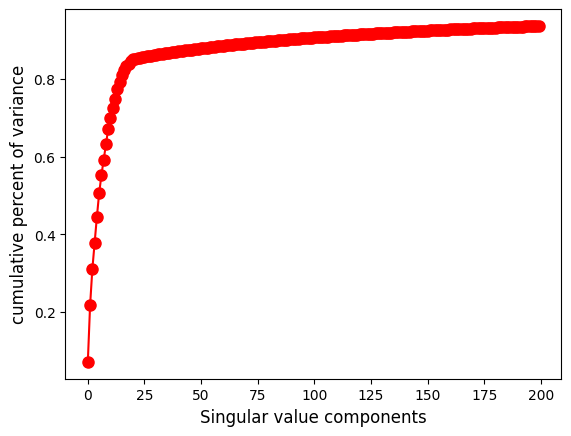

In [52]:
# Compress with SVD (singular value decomposition)
# SVD works very well for the sparse matrix
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components', fontsize=12)
plt.ylabel('cumulative percent of variance', fontsize=12)
plt.show()

In [53]:
#number of latent dimensions to keep
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [54]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,0.014749,-0.013985,-0.229700,-0.141852,0.010083,0.003342,0.012844,-0.068396,0.073705,-0.069584
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,-0.016960,0.002085,0.001940,0.009180,-0.005391,0.001927,0.017154,-0.024853,0.003812,-0.000617
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,0.002193,0.001821,0.001142,0.000979,0.000010,0.003906,-0.001152,0.004008,-0.000042,-0.001926
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,0.000078,0.000277,-0.000160,-0.000085,-0.000219,-0.000115,-0.000045,-0.000533,-0.000183,-0.000396
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,-0.003381,0.008207,-0.006053,-0.001124,0.003321,-0.007630,-0.015006,-0.004195,-0.005467,-0.005329


In [55]:
# our content latent matrix:
latent_matrix_1_df.shape

(9625, 200)

In [56]:
ratings_f

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [57]:
#ratings_f1 will contain all the ratings from ratings_f, but only for the movies that are present in the movies DataFrame.
#Any ratings for movies not in the movies DataFrame will not be included.
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on='movieId', how='right')
ratings_f1

,movieId,userId,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0
...,...,...,...
92724,166534,610,4.0
92725,168248,610,5.0
92726,168250,610,5.0
92727,168252,610,5.0


In [58]:
# ratings_f2 will be a matrix-like DataFrame where rows represent movie IDs,
# columns represent user IDs, and the values represent the ratings given by users to movies.
# Any missing ratings will be filled with 0.
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns='userId', values = 'rating').fillna(0)

In [59]:
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [60]:
ratings_f2.shape

(9625, 364)

In [61]:
len(ratings_f.movieId.unique())

9625

In [62]:
#latent_matrix_2_df contains the latent representations of movies based on collaborative filtering,
# with each row representing a movie and each column representing a latent feature.
# This matrix captures the underlying patterns in user ratings and allows for collaborative filtering-based recommendation.

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [63]:
latent_matrix_2_df.shape

(9625, 200)

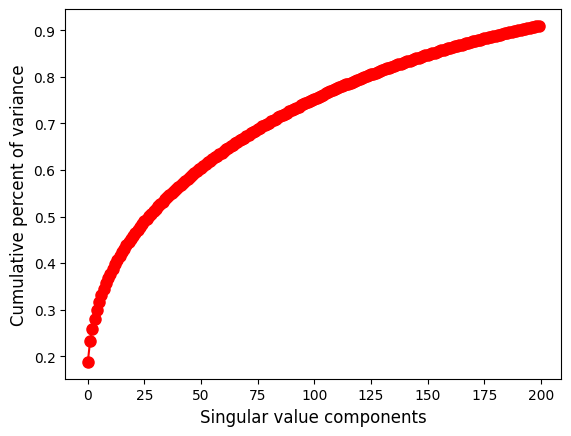

In [64]:
#plot variance explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms=16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [65]:
#This is my content matrix.
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,0.102600,0.082370,0.069459,0.091250,-0.151136,0.012090,0.234567,-0.019392,-0.124586,-0.008614,...,0.014749,-0.013985,-0.229700,-0.141852,0.010083,0.003342,0.012844,-0.068396,0.073705,-0.069584
Jumanji,0.032689,0.008539,0.059189,0.091842,-0.106015,0.007100,0.189676,-0.012325,-0.078054,0.001669,...,-0.016960,0.002085,0.001940,0.009180,-0.005391,0.001927,0.017154,-0.024853,0.003812,-0.000617
Grumpier Old Men,0.148118,0.105052,-0.042318,0.121888,0.098552,-0.040117,-0.011973,0.000952,0.004727,-0.002093,...,0.002193,0.001821,0.001142,0.000979,0.000010,0.003906,-0.001152,0.004008,-0.000042,-0.001926
Waiting to Exhale,0.824508,0.064191,-0.292164,0.377882,0.274419,-0.082577,-0.046063,0.001273,0.028399,-0.000377,...,0.000078,0.000277,-0.000160,-0.000085,-0.000219,-0.000115,-0.000045,-0.000533,-0.000183,-0.000396
Father of the Bride Part II,0.113317,0.120747,-0.006328,-0.037081,-0.007424,0.010526,-0.009221,-0.001934,0.004463,-0.011439,...,-0.003381,0.008207,-0.006053,-0.001124,0.003321,-0.007630,-0.015006,-0.004195,-0.005467,-0.005329


In [66]:
#This is my collaborative matrix.
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story,36.391240,-4.958788,14.331820,1.844157,-3.077922,-1.351171,8.341426,-0.561089,-1.898201,1.657856,...,-2.631706,2.933721,-0.301446,-1.708472,0.112895,-0.401118,1.294494,-0.463283,-0.659463,0.805108
Jumanji,20.447499,0.675231,11.354479,-7.325453,-3.505243,3.585611,4.393396,-5.564560,0.434472,0.351436,...,0.533444,0.976044,-0.741450,1.385240,1.001029,0.523301,-1.181238,-0.102851,-0.521689,-0.629146
Grumpier Old Men,8.407816,-5.190801,4.378314,-6.189039,-0.333121,1.924149,-1.548363,0.795946,-3.196045,2.121791,...,0.172474,0.798497,0.181800,0.395610,0.232721,-0.543480,-0.094217,-0.640195,0.576213,0.201544
Waiting to Exhale,0.408037,-0.664700,0.739903,-0.202676,-0.498374,1.055409,0.184081,-0.508293,-0.429505,0.086538,...,0.080302,-0.292591,0.059751,-0.127310,0.137057,0.172019,0.058723,-0.110085,0.049987,-0.097510
Father of the Bride Part II,5.755079,-1.757369,3.961287,-3.673278,-3.688047,3.237859,1.140585,-0.690785,-2.171826,1.365962,...,0.776777,-0.134448,0.477992,-0.723558,-0.114641,0.397694,-0.393561,-0.176149,0.055656,0.591387


In [67]:
pickle.dump(latent_matrix_2_df, open('latent_matrix_2_df.pkl', 'wb'))

In [68]:
pickle.dump(latent_matrix_1_df, open('latent_matrix_1_df.pkl', 'wb'))

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie from both content and collaborative matrixes
a_1=np.array(latent_matrix_1_df.loc['Spider-Man']).reshape(1,-1)
a_2=np.array(latent_matrix_2_df.loc['Spider-Man']).reshape(1,-1)

#calculate the similarity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)
print(score_1)
print(np.sort(score_1)[::-1])
#an avg measure of both content and collaborative
hybrid = ((score_1 + score_2)/2.0)

#form a data frame of similar movies
dictDf = {'content': score_1, 'collaborative':score_2, 'hybrid':hybrid}

# Constructs a DataFrame named 'similar' using the similarity scores dictionary.
# Each row represents a movie, and columns represent the three similarity scores.
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

#sort it on the basis of either: content, collaborative or hybrid,
#here : hybrid
similar.sort_values('hybrid', ascending=False, inplace=True)
print(a_1.shape,"  ",a_2.shape,"   ",score_1.shape,"   ",score_2.shape,"   ",latent_matrix_2_df.shape)
# Displays the top 10 similar movies (excluding the first row, which represents "Toy Story (1995)") based on the hybrid similarity score.
similar[1:].head(11)



[ 5.84674837e-02  6.44363372e-02 -5.01942756e-05 ... -7.69995161e-06
  1.58728587e-01  6.72916059e-06]
[ 1.          0.99482996  0.96224311 ... -0.00630422 -0.00978162
 -0.01180925]
(1, 200)    (1, 200)     (9625,)     (9625,)     (9625, 200)


,content,collaborative,hybrid
X2: X-Men United,0.994830,0.728121,0.861475
X-Men,0.717776,0.722281,0.720028
Superman,0.962243,0.435005,0.698624
Star Wars: Episode I - The Phantom Menace,0.635718,0.676881,0.656299
Spider-Man 2,0.487077,0.790278,0.638677
Star Wars: Episode II - Attack of the Clones,0.489886,0.784537,0.637211
"Matrix Reloaded, The",0.550454,0.723021,0.636738
"I, Robot",0.692039,0.577901,0.634970
"Fifth Element, The",0.606658,0.654045,0.630352
Superman II,0.909733,0.347464,0.628598


In [46]:
!pip install fuzzywuzzy
# it is used to find the closest match if the spelling is wrong in the input movie name

In [47]:
!pip install python-Levenshtein
# it is also necessary to install when we install fuzzywuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.1 MB/s eta 0:00:00


In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process

def movie_finder(title, all_titles):
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

def get_movie_recommendations(movie_name, latent_matrix_1_df, latent_matrix_2_df):

    # Use movie_finder to correct the user input
    corrected_movie = movie_finder(movie_name, Final['title'].tolist())

    # Print the corrected movie name
    print(f"Corrected Movie Input: {corrected_movie}")

    # Get the index of the corrected movie in the dataset
    # index = movies[movies['title'] == corrected_movie].index[0]
    # Take the latent vectors for the selected movie from both content and collaborative matrices
    a_1 = np.array(latent_matrix_1_df.loc[corrected_movie]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[corrected_movie]).reshape(1, -1)

    # Calculate the similarity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # Calculate the hybrid score as the average of content and collaborative scores
    hybrid = ((score_1 + score_2) / 2.0)

    # Form a data frame of similar movies
    dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

    # Sort it based on the hybrid similarity score
    similar.sort_values('hybrid', ascending=False, inplace=True)

    # Return top 10 similar movies (excluding the input movie)
    return similar[1:].head(11)

# Example usage:
# Replace 'latent_matrix_1_df' and 'latent_matrix_2_df' with your actual DataFrames containing latent vectors
# Replace 'movie_name' with the movie for which you want recommendations
recommendations = get_movie_recommendations('Spider Man', latent_matrix_1_df, latent_matrix_2_df)
print(recommendations)


Corrected Movie Input: Spider-Man
                                               content  collaborative  \
X2: X-Men United                              0.994830       0.728121   
X-Men                                         0.717776       0.722281   
Superman                                      0.962243       0.435005   
Star Wars: Episode I - The Phantom Menace     0.635718       0.676881   
Spider-Man 2                                  0.487077       0.790278   
Star Wars: Episode II - Attack of the Clones  0.489886       0.784537   
Matrix Reloaded, The                          0.550454       0.723021   
I, Robot                                      0.692039       0.577901   
Fifth Element, The                            0.606658       0.654045   
Superman II                                   0.909733       0.347464   
Batman                                        0.763262       0.470549   

                                                hybrid  
X2: X-Men United                

In [71]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from fuzzywuzzy import process

def movie_finder(title, all_titles):
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

def get_movie_recommendations(movie_name, latent_matrix_1_df, latent_matrix_2_df):

    # Use movie_finder to correct the user input
    corrected_movie = movie_finder(movie_name, Final['title'].tolist())

    # Print the corrected movie name
    print(f"Corrected Movie Input: {corrected_movie}")

    # Get the index of the corrected movie in the dataset
    # index = movies[movies['title'] == corrected_movie].index[0]
    # Take the latent vectors for the selected movie from both content and collaborative matrices
    a_1 = np.array(latent_matrix_1_df.loc[corrected_movie]).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc[corrected_movie]).reshape(1, -1)

    # Calculate the similarity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # Calculate the hybrid score as the average of content and collaborative scores
    hybrid = ((score_1 + score_2) / 2.0)



    # Form a data frame of similar movies
    dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid}
    similar = pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

    # Sort it based on the hybrid similarity score
    similar.sort_values('hybrid', ascending=False, inplace=True)

    # Exclude the input movie from recommendations
    similar = similar.drop(corrected_movie, errors='ignore')

    # Print top 10 similar movies (excluding the input movie) based on hybrid score
    print("\nTop 10 Recommendations (Hybrid Score):")
    print(similar[['hybrid']].head(10))

    # Print top 10 similar movies based on content score
    print("\nTop 10 Recommendations (Content Score):")
    print(similar[['content']].sort_values('content', ascending=False).head(10))

    # Print top 10 similar movies based on collaborative score
    print("\nTop 10 Recommendations (Collaborative Score):")
    print(similar[['collaborative']].sort_values('collaborative', ascending=False).head(10))

# Example usage:
# Replace 'latent_matrix_1_df' and 'latent_matrix_2_df' with your actual DataFrames containing latent vectors
# Replace 'movies_data' with your DataFrame containing movie data
# Replace 'movie_name' with the movie for which you want recommendations
get_movie_recommendations('Spider Man', latent_matrix_1_df, latent_matrix_2_df)


Corrected Movie Input: Spider-Man

Top 10 Recommendations (Hybrid Score):
                                                hybrid
X2: X-Men United                              0.861475
X-Men                                         0.720028
Superman                                      0.698624
Star Wars: Episode I - The Phantom Menace     0.656299
Spider-Man 2                                  0.638677
Star Wars: Episode II - Attack of the Clones  0.637211
Matrix Reloaded, The                          0.636738
I, Robot                                      0.634970
Fifth Element, The                            0.630352
Superman II                                   0.628598

Top 10 Recommendations (Content Score):
                   content
X2: X-Men United  0.994830
Superman          0.962243
Superman III      0.962243
Superman II       0.909733
Man of Steel      0.810478
Batman Forever    0.784935
Supergirl         0.764243
Batman            0.763262
X-Men             0.717776
Batman Ret

In [72]:
import pickle

In [73]:
movie_details.head(3)

,movieId,title,genres,release_year,tag,metadata
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji,Adventure Children Fantasy,1995,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men,Comedy Romance,1995,moldy old,moldy old Comedy Romance


In [74]:
movie_details  = movie_details.drop(columns=['tag','metadata'])
# drop the tag and metadata column

In [75]:
movie_details.head(3)

,movieId,title,genres,release_year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995


In [76]:
pickle.dump(movie_details, open('movies_list_hybrid.pkl', 'wb'))